<a href="https://colab.research.google.com/github/zeligism/ConGAN/blob/main/ConsistentGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive

In [255]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Header

## Imports

In [256]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import glob
import random
import datetime
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.utils.tensorboard as tensorboard

from PIL import Image, ImageDraw
from math import log2
from pprint import pformat
from collections import defaultdict

## Utility Functions

### Report Utils

In [257]:
def plot_lines(losses_dict, filename=None, title=""):
    """
    Plots the losses of the discriminator and the generator.

    Args:
        filename: The plot's filename. If None, plot won't be saved.
    """

    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    
    if filename is not None:
        plt.savefig(filename)
    
    plt.show()
    plt.close()


def create_progress_animation(frames, filename):
    """
    Creates a video of the progress of the generator on a fixed latent vector.

    Args:
        filename: The animation's filename.
    """

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(img.permute(1,2,0), animated=True)]
           for img in frames]
    ani = animation.ArtistAnimation(fig, ims, blit=True)
    
    ani.save(filename)

    plt.close()


def generate_grid(generator, latent):
    """
    Check generator's output on latent vectors and return it.

    Args:
        generator: The generator.
        latent: Latent vector from which an image grid will be generated.

    Returns:
        A grid of images generated by `generator` from `latent`.
    """

    with torch.no_grad():
        fake = generator(latent).detach()

    image_grid = vutils.make_grid(fake.cpu(), padding=2, normalize=True, range=(-1,1))

    return image_grid



# Classes

## PyTorch Modules

### DCGAN

In [258]:
class ConvBlock(nn.Module):
    """
    Default stride and padding half the size of features,
    e.g. if input is [in_channels, 64, 64], output will be [out_channels, 32, 32].
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.conv = nn.utils.parametrizations.spectral_norm(self.conv)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class ConvTBlock(nn.Module):
    """
    Default stride and padding double the size of features,
    e.g. if input is [in_channels, 32, 32], output will be [out_channels, 64, 64].
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                        stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.convT = nn.utils.parametrizations.spectral_norm(self.convT)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.ReLU(inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.convT(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class DCGAN_Discriminator(nn.Module):
    def __init__(self,
                 num_latents=16,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 output_sigmoid=True,
                 D_block=ConvBlock):
        super().__init__()

        using_grad_penalty = gan_type in ("gan-gp", "wgan-gp")
        output_sigmoid = output_sigmoid and gan_type in ("gan", "gan-gp")

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm and not using_grad_penalty,
            "use_spectralnorm": use_spectralnorm,
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(max_features, round(num_features * feature_multiplier**i))
                    for i in range(num_layers)]

        # Input layer
        self.input_layer = D_block(image_channels, features[0], **block_config)

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            D_block(in_features, out_features, **block_config)
            for in_features, out_features in zip(features, features[1:])
        ])

        # Output layer (feature_size = 3, 4, or 5 -> 1)
        if fully_convolutional:
            conv = nn.Conv2d(features[-1], num_latents, latent_kernel, bias=False)
            if use_spectralnorm:
                conv = nn.utils.parametrizations.spectral_norm(conv)
            self.output_layer = nn.Sequential(conv, nn.Flatten())
        else:
            linear = nn.Linear(features[-1] * latent_kernel**2, num_latents, bias=False)
            if use_spectralnorm:
                linear = nn.utils.parametrizations.spectral_norm(linear)
            self.output_layer = nn.Sequential(nn.Flatten(), linear)
        
        self.hidden_dim = features[-1] * latent_kernel**2

        # Add sigmoid activation if using regular GAN loss
        self.output_activation = nn.Sigmoid() if output_sigmoid else None

    def forward(self, x):
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        if self.output_activation:
            x = self.output_activation(x)
        # Remove H and W dimensions, infer channels dim (remove if 1)
        x = x.view(x.size(0), -1).squeeze(1)
        return x


class DCGAN_Generator(nn.Module):
    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 G_block=ConvTBlock):
        super().__init__()

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(max_features, round(num_features * feature_multiplier**i))
                    for i in range(num_layers)]

        # Reverse order of image sizes and features for generator
        image_sizes = image_sizes[::-1]
        features = features[::-1]

        # Input layer
        if fully_convolutional:
            self.input_layer = G_block(num_latents, features[0], kernel_size=latent_kernel,
                                       stride=1, padding=0, **block_config)
        else:
            self.input_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_latents, features[0] * image_sizes[0]**2, bias=False),
                View(features[0], image_sizes[0], image_sizes[0])
            )

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            G_block(in_features, out_features, kernel_size=4+(expected_size%2), **block_config)
            for in_features, out_features, expected_size in zip(features, features[1:], image_sizes[1:])
        ])

        # Output layer
        self.output_layer = nn.ConvTranspose2d(features[-1], image_channels, kernel_size=4+(image_size%2),
                                               stride=2, padding=1, bias=False)
        self.output_activation = nn.Tanh()

    def forward(self, x):
        # Add H and W dimensions, infer channels dim (add if none)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x


class DCGAN(nn.Module):
    """Deep Convolutional Generative Adversarial Network"""

    def __init__(self,
                 num_latents=100,
                 D_num_features=64,
                 G_num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 output_sigmoid=True,):
        """
        Initializes DCGAN.

        Args:
            num_latents: Number of latent factors.
            num_features: Number of features in the convolutions.
            image_channels: Number of channels in the input image.
            image_size: Size (i.e. height or width) of image.
            gan_type: Type of GAN (e.g. "gan" or "wgan-gp").
        """
        super().__init__()

        self.num_latents = num_latents
        self.D_num_features = D_num_features
        self.G_num_features = G_num_features
        self.image_channels = image_channels
        self.image_size = image_size
        self.feature_multiplier = feature_multiplier
        self.gan_type = gan_type
        self.fully_convolutional = fully_convolutional
        self.activation = activation
        self.use_batchnorm = use_batchnorm
        self.use_spectralnorm = use_spectralnorm

        D_params = {
            "num_latents": 1,  # XXX
            "num_features": D_num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
            "output_sigmoid": output_sigmoid,
        }
        G_params = {
            "num_latents": num_latents,
            "num_features": G_num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": True,
            "use_spectralnorm": False,  # XXX
        }

        self.D = DCGAN_Discriminator(**D_params)
        self.G = DCGAN_Generator(**G_params)


class View(nn.Module):
    def __init__(self, *shape, including_batch=False):
        super().__init__()
        self.shape = shape
        self.including_batch = including_batch
    
    def forward(self, x):
        if self.including_batch:
            return x.view(*self.shape)
        else:
            return x.view(x.size(0), *self.shape)

class ChannelNoise(nn.Module):
    """
    Channel noise injection module.
    Adds a linearly transformed noise to a convolution layer.
    """

    def __init__(self, num_channels, std=0.02):
        super().__init__()
        self.std = std
        self.scale = nn.Parameter(torch.ones(1, num_channels, 1, 1))


    def forward(self, x):
        noise_size = [x.size()[0], 1, *x.size()[2:]]  # single channel
        noise = self.std * torch.randn(noise_size).to(x)

        return x + self.scale * noise

### Third-party modules

#### DCGAN

In [259]:
class ConditionalBatchNorm2d(nn.Module):
  def __init__(self, num_features, repr_dim):
    super().__init__()
    self.num_features = num_features
    self.bn = nn.BatchNorm2d(num_features, affine=False)
    self.embed = nn.Linear(repr_dim, num_features * 2)
    self.embed.weight.data[:, :num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
    self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0

  def forward(self, x, y):
    out = self.bn(x)
    gamma, beta = self.embed(y).chunk(2, 1)
    out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
    return out


#https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/model.py

from torch.nn.utils.parametrizations import spectral_norm

class SNDCGAN_Generator(nn.Module):
    def __init__(self, z_dim, num_features=64, channels=3, repr_dim=None):
        super().__init__()
        self.z_dim = z_dim

        self.conv1 = nn.ConvTranspose2d(z_dim, 8*num_features, 4, stride=1)
        self.bn1 = ConditionalBatchNorm2d(8*num_features, repr_dim)
        self.conv2 = nn.ConvTranspose2d(8*num_features, 4*num_features, 4, stride=2, padding=(1,1))
        self.bn2 = ConditionalBatchNorm2d(4*num_features, repr_dim)
        self.conv3 = nn.ConvTranspose2d(4*num_features, 2*num_features, 4, stride=2, padding=(1,1))
        self.bn3 = ConditionalBatchNorm2d(2*num_features, repr_dim)
        self.conv4 = nn.ConvTranspose2d(2*num_features, num_features, 4, stride=2, padding=(1,1))
        self.bn4 = ConditionalBatchNorm2d(num_features, repr_dim)
        self.conv5 = nn.ConvTranspose2d(num_features, channels, 3, stride=1, padding=(1,1))
        # use this instead of last line for 64:
        # nn.ConvTranspose2d(64, 32, 4, stride=2, padding=(1,1))
        self.block_activation = nn.ReLU()
        self.output_activation = nn.Tanh()

    def forward(self, z, repr=None):
        h = z.view(-1, self.z_dim, 1, 1)
        h = self.block_activation(self.bn1(self.conv1(h), repr))
        h = self.block_activation(self.bn2(self.conv2(h), repr))
        h = self.block_activation(self.bn3(self.conv3(h), repr))
        h = self.block_activation(self.bn4(self.conv4(h), repr))
        return self.output_activation(self.conv5(h))

class SNDCGAN_Discriminator(nn.Module):
    def __init__(self, num_features=64, channels=3):
        super().__init__()

        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(channels, num_features, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(num_features, num_features, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(num_features, 2*num_features, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(2*num_features, 2*num_features, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(2*num_features, 4*num_features, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(4*num_features, 4*num_features, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(4*num_features, 8*num_features, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            # use this instead of last 2 lines for 64:
            # spectral_norm(nn.Conv2d(256, 256, 3, stride=1, padding=(1,1))),
            # nn.LeakyReLU(0.1, inplace=True),
            # spectral_norm(nn.Conv2d(256, 512, 3, stride=1, padding=(1,1))),
            # nn.LeakyReLU(0.1, inplace=True),
            nn.Flatten(),
        )

        self.hidden_dim = 4*4 * 8*num_features
        self.fc = spectral_norm(nn.Linear(self.hidden_dim, 1))

    def forward(self, x, return_h=False):
        h = self.main(x)
        out = self.fc(h).squeeze(1)
        if return_h:
            return out, h
        else:
            return out


class SNDCGAN(nn.Module):
    def __init__(self, num_latents, num_features=64, channels=3, repr_dim=None):
        super().__init__()
        self.num_latents = num_latents
        self.channels = channels
        self.D = SNDCGAN_Discriminator(channels=channels, num_features=num_features)
        self.G = SNDCGAN_Generator(num_latents, channels=channels,
                                   num_features=num_features, repr_dim=repr_dim)
    

#### ResNet GAN

In [260]:
# https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/model_resnet.py

from torch.nn.utils.parametrizations import spectral_norm

class ResBlockGenerator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlockGenerator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        nn.init.xavier_uniform_(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform_(self.conv2.weight.data, 1.)

        self.model = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            self.conv1,
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            self.conv2
            )
        self.bypass = nn.Sequential()
        if stride != 1:
            self.bypass = nn.Upsample(scale_factor=2)

    def forward(self, x):
        return self.model(x) + self.bypass(x)


class ResBlockDiscriminator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlockDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        nn.init.xavier_uniform_(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform_(self.conv2.weight.data, 1.)

        if stride == 1:
            self.model = nn.Sequential(
                nn.ReLU(),
                spectral_norm(self.conv1),
                nn.ReLU(),
                spectral_norm(self.conv2)
                )
        else:
            self.model = nn.Sequential(
                nn.ReLU(),
                spectral_norm(self.conv1),
                nn.ReLU(),
                spectral_norm(self.conv2),
                nn.AvgPool2d(2, stride=stride, padding=0)
                )
        self.bypass = nn.Sequential()
        if stride != 1:

            self.bypass_conv = nn.Conv2d(in_channels,out_channels, 1, 1, padding=0)
            nn.init.xavier_uniform_(self.bypass_conv.weight.data, np.sqrt(2))

            self.bypass = nn.Sequential(
                spectral_norm(self.bypass_conv),
                nn.AvgPool2d(2, stride=stride, padding=0)
            )
            # if in_channels == out_channels:
            #     self.bypass = nn.AvgPool2d(2, stride=stride, padding=0)
            # else:
            #     self.bypass = nn.Sequential(
            #         spectral_norm(nn.Conv2d(in_channels,out_channels, 1, 1, padding=0)),
            #         nn.AvgPool2d(2, stride=stride, padding=0)
            #     )


    def forward(self, x):
        return self.model(x) + self.bypass(x)

# special ResBlock just for the first layer of the discriminator
class FirstResBlockDiscriminator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(FirstResBlockDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        self.bypass_conv = nn.Conv2d(in_channels, out_channels, 1, 1, padding=0)
        nn.init.xavier_uniform_(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform_(self.conv2.weight.data, 1.)
        nn.init.xavier_uniform_(self.bypass_conv.weight.data, np.sqrt(2))

        # we don't want to apply ReLU activation to raw image before convolution transformation.
        self.model = nn.Sequential(
            spectral_norm(self.conv1),
            nn.ReLU(),
            spectral_norm(self.conv2),
            nn.AvgPool2d(2)
            )
        self.bypass = nn.Sequential(
            nn.AvgPool2d(2),
            spectral_norm(self.bypass_conv),
        )

    def forward(self, x):
        return self.model(x) + self.bypass(x)

class SNResNet_Generator(nn.Module):
    def __init__(self, z_dim, image_size=64, channels=3):
        super().__init__()
        self.z_dim = z_dim
        self.image_size = image_size

        self.dense = nn.Linear(self.z_dim, 4 * 4 * image_size)
        self.final = nn.Conv2d(image_size, channels, 3, stride=1, padding=1)
        nn.init.xavier_uniform_(self.dense.weight.data, 1.)
        nn.init.xavier_uniform_(self.final.weight.data, 1.)

        self.model = nn.Sequential(
            ResBlockGenerator(image_size, image_size, stride=2),
            ResBlockGenerator(image_size, image_size, stride=2),
            ResBlockGenerator(image_size, image_size, stride=2),
            nn.BatchNorm2d(image_size),
            nn.ReLU(),
            self.final,
            nn.Tanh())

    def forward(self, z):
        return self.model(self.dense(z).view(-1, self.image_size, 4, 4))

class SNResNet_Discriminator(nn.Module):
    def __init__(self, image_size=64, channels=3):
        super().__init__()
        self.image_size = image_size

        self.model = nn.Sequential(
                FirstResBlockDiscriminator(channels, image_size, stride=2),
                ResBlockDiscriminator(image_size, image_size, stride=2),
                ResBlockDiscriminator(image_size, image_size),
                ResBlockDiscriminator(image_size, image_size),
                nn.ReLU(),
                nn.AvgPool2d(8),
            )
        self.fc = nn.Linear(image_size, 1)
        nn.init.xavier_uniform_(self.fc.weight.data, 1.)
        self.fc = spectral_norm(self.fc)

    def forward(self, x):
        return self.fc(self.model(x).view(-1, self.image_size))


class SNResNetGAN(nn.Module):
    def __init__(self, num_latents, image_size=64, channels=3):
        super().__init__()
        self.num_latents = num_latents
        self.channels = channels
        self.D = SNResNet_Discriminator(image_size=image_size, channels=channels)
        self.G = SNResNet_Generator(num_latents, image_size=image_size, channels=channels)


#### SimSiam

In [261]:
class SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, base_encoder, dim=2048, pred_dim=512):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(SimSiam, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = base_encoder(num_classes=dim, zero_init_residual=True)

        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        # build a 2-layer predictor
        self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), # hidden layer
                                        nn.Linear(pred_dim, dim)) # output layer

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        # compute features for one view
        z1 = self.encoder(x1) # NxC
        z2 = self.encoder(x2) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        return p1, p2, z1.detach(), z2.detach()

### Latent Transform

In [262]:
class LatentTransform(nn.Module):
    def __init__(self, repr_dim, latent_dim, hidden_dim, full_transform=True, noop=False):
        super().__init__()

        self.repr_dim = repr_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.full_transform = full_transform
        self.noop = noop

        if self.noop:
            self.output_dim = self.latent_dim
            return
        elif self.full_transform:
            self.input_dim = self.repr_dim + self.latent_dim
            self.output_dim = self.hidden_dim
        else:
            self.input_dim = self.repr_dim
            self.output_dim = self.hidden_dim + self.latent_dim

        self.transform = nn.Linear(self.input_dim, self.hidden_dim)
    
    def forward(self, repr, noise):
        if self.noop:
            return noise

        # assuming latent is concat as [repr,noise] XXX
        if self.full_transform:
            latent = torch.cat([repr, noise], dim=1)
            latent = self.transform(latent)
        else:
            repr = self.transform(repr)
            latent = torch.cat([repr, noise], dim=1)

        return latent


# Training v2

### Imports and globals

In [263]:
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

GANSIAM_DIR = "/content/drive/My Drive/gansiam/"
SIMSIAM_PATH = os.path.join(GANSIAM_DIR, "pretrained_batch256.tar")
TINYIMAGENET_DIR = "tiny-imagenet-200"

### Download Tiny Imagenet

In [264]:
%%bash
if [[ -d  "tiny-imagenet-200" ]]; then
    echo "Tiny Imagenet exists."
else
    wget -q "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    unzip -qq "tiny-imagenet-200.zip" && rm "tiny-imagenet-200.zip"
    echo "Downloaded Tiny Imagenet."
fi

Tiny Imagenet exists.


### Load pre-trained SimSiam model


#### SimSiam Utils

In [265]:
from PIL import ImageFilter
import random


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


In [266]:
checkpoint = torch.load(SIMSIAM_PATH, map_location="cuda:0")
# remove 'module.' from dict keys
model_dict = OrderedDict((k[7:], v) for k, v in checkpoint["state_dict"].items())

# Load model
simsiam = SimSiam(models.__dict__["resnet50"])
simsiam.load_state_dict(model_dict)
#print(simsiam)

<All keys matched successfully>

# Training v3

## Args

In [267]:
class Args:
    def __init__(self):
        self.load = True
        self.print_freq = 10
        self.seed = None
        self.gpu = 0
        self.workers = 2
        self.epochs = 100

        ### lr is about 2e-4 for batch size of 64
        # we scale according to our choice of batch size
        self.batch_size = 64
        self.D_lr = 2e-4 * (64 / self.batch_size)
        self.G_lr = 2e-4 * (64 / self.batch_size)
        self.Q_lr = self.D_lr
        self.latent_transform_lr = self.G_lr
        self.lr_decay = 0.01
        #self.betas = (0.5, 0.999)
        self.betas = (0., 0.9)

        # SimSiam (_don't change_ if loading pre-trained)
        self.dim = 2048
        self.pred_dim = 512

        # GAN
        self.repr_dim = self.dim  # don't change
        self.latent_full_transform = False
        self.latent_noise_dim = 128
        self.latent_hidden_dim = 128  # dim of transform output
        self.Q_hidden_dim = 128
        self.num_features = 64
        self.D_iters = 5

        self.gan_type = "gan"  # ignore this
        self.wgan = False  # if False, use spectral norm
        self.grad_penalty = 0.  # 0 if wgan is False
        self.grad_center = 1.  # not important

        self.generate_grid_interval = 100

        # make noise proportional to sd(data)
        self.im_noise = 1e-2  # image sd is about 1.0
        self.repr_noise = 1e-4  # repr sd is about 1e-3

        # Start small, increase later
        self.G_consistency = 0.1
        self.D_consistency = 0.1


GENERATED_GRIDS = []
IMAGE_SIZE = 32
DATASET = "CIFAR10"
args = Args()

## Data

In [268]:
# image normalization
#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]
mean = [0.5]
std = [0.5]
normalize = transforms.Normalize(mean=mean, std=std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

augmentation = [
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
_augmentation = [
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

if DATASET == "MNIST":
    augmentation = [transforms.Grayscale(3)] + augmentation
    train_dataset = datasets.MNIST(
        root=os.path.join(GANSIAM_DIR, "mnist/train"), train=True, download=True,
        transform=transforms.Compose(augmentation))
elif DATASET == "CelebA":
    train_dataset = datasets.CelebA(
        root=os.path.join(GANSIAM_DIR, "celeba"), download=True,
        transform=transforms.Compose(augmentation))
elif DATASET == "CIFAR10":
    train_dataset = datasets.CIFAR10(
        root=os.path.join(GANSIAM_DIR, "cifar10/train"), train=True, download=True,
        transform=transforms.Compose(augmentation))
        #transform=TwoCropsTransform(transforms.Compose(augmentation)))
elif DATASET == "Tiny Imagenet":
    train_dataset = datasets.ImageFolder(
        root=os.path.join(TINYIMAGENET_DIR, 'train'),
        transform=transforms.Compose(augmentation))
else:
    raise Exception(f"Dataset '{DATASET}' not found")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, sampler=None, drop_last=True)

Files already downloaded and verified


### Losses

In [269]:
def D_criterion_NS(D_real, D_fake):
    d_loss = F.softplus(-D_real) + F.softplus(D_fake)
    return d_loss.mean()

def G_criterion_NS(D_fake):
    return F.softplus(-D_fake).mean()

def D_criterion_LS(D_real, D_fake):
    d_loss = 0.5 * (D_real - torch.ones_like(D_real))**2 + 0.5 * (D_fake)**2
    return d_loss.mean()

def G_criterion_LS(D_fake):
    gen_loss = 0.5 * (D_fake - torch.ones_like(D_fake))**2
    return gen_loss.mean()

def D_criterion_hinge(D_real, D_fake):
    return torch.mean(F.relu(1. - D_real)) + torch.mean(F.relu(1. + D_fake))

def G_criterion_hinge(D_fake):
    return -torch.mean(D_fake)

def D_criterion_wasserstein(D_real, D_fake):
    return torch.mean(D_fake - D_real)

def G_criterion_wasserstein(D_fake):
    return -torch.mean(D_fake)

def interpolate(real, fake, eps=None):
    if eps is None:
        eps_size = [1] * len(real.size())
        eps_size[0] = real.size(0)
        eps = torch.rand(eps_size).to(real)
    return eps * real + (1 - eps) * fake
    
def simple_gradient_penalty(D, x, center=0.):
    x.requires_grad_()
    D_x = D(x)
    D_grad = torch.autograd.grad(D_x, x, torch.ones_like(D_x), create_graph=True)
    D_grad_norm = D_grad[0].view(x.size(0), -1).norm(dim=1)
    return (D_grad_norm - center).pow(2).mean()

def lerp(x1, x2, t=None):
    return interpolate(x1, x2, t)

def slerp(x1, x2, t=None):
    if t is None:
        t = torch.rand(x1.size(0)).to(x1)
    # assuming normalized x and x2
    omega = torch.acos((x1*x2).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.-t)*omega) / so).unsqueeze(1) * x1 \
        + (torch.sin(t*omega) / so).unsqueeze(1) * x2
    return res


## Model + Opt

In [274]:
if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True

torch.cuda.set_device(args.gpu)

latent_transform = LatentTransform(repr_dim=args.repr_dim,
                                   latent_dim=args.latent_noise_dim,
                                   hidden_dim=args.latent_hidden_dim,
                                   full_transform=args.latent_full_transform,
                                   )

model = DCGAN(num_latents=latent_transform.output_dim,
              image_size=IMAGE_SIZE,
              gan_type=args.gan_type,  # doesn't make a difference
              D_num_features=args.num_features,
              G_num_features=args.num_features,
              use_batchnorm=False,  # for D only
              output_sigmoid=False,  # for D only
              use_spectralnorm=not args.wgan,  # for spectral norm, use the below model
              )


if not args.wgan:
    model = SNDCGAN(num_latents=latent_transform.output_dim,
                    num_features=args.num_features,
                    repr_dim=args.repr_dim)

if args.D_consistency == 0.:
    Q = nn.Module()
else:
    Q_hidden_dim = args.Q_hidden_dim
    Q = nn.Sequential(nn.Linear(model.D.hidden_dim, Q_hidden_dim, bias=False),
                      nn.Linear(Q_hidden_dim, args.repr_dim))

model = model.cuda(args.gpu)
Q = Q.cuda(args.gpu)
latent_transform = latent_transform.cuda(args.gpu)
simsiam = simsiam.cuda(args.gpu)

print("Num of params in D:", sum(map(torch.numel, model.D.parameters())))
print("Num of params in G:", sum(map(torch.numel, model.G.parameters())))
print("Num of params in Q:", sum(map(torch.numel, Q.parameters())))
print("Num of params in L:", sum(map(torch.numel, latent_transform.parameters())))

# Define D and G loss functions
if args.wgan:
    args.grad_penalty = 10.
    D_criterion = D_criterion_wasserstein
    G_criterion = G_criterion_wasserstein
else:
    args.grad_penalty = 0.
    D_criterion = D_criterion_hinge
    G_criterion = G_criterion_hinge

# Optimizers
G_optimizer = torch.optim.Adam(
    [{"params": model.G.parameters()},
     {"params": latent_transform.parameters(), "lr": args.latent_transform_lr}],
     args.G_lr, betas=args.betas)
D_optimizer = torch.optim.Adam(
    [{"params": model.D.parameters(), "lr": args.D_lr},
     {"params": Q.parameters(), "lr": args.Q_lr}],
     args.Q_lr, betas=args.betas)

D_sched = torch.optim.lr_scheduler.ExponentialLR(D_optimizer, 1. - args.lr_decay)
G_sched = torch.optim.lr_scheduler.ExponentialLR(G_optimizer, 1. - args.lr_decay)

cudnn.benchmark = True

if args.load:
    model.load_state_dict(torch.load(f"{GANSIAM_DIR}/results/model.pth.tar")["state_dict"])
    latent_transform.load_state_dict(torch.load(f"{GANSIAM_DIR}/results/latent_transform.pth.tar")["state_dict"])
    Q.load_state_dict(torch.load(f"{GANSIAM_DIR}/results/Q.pth.tar")["state_dict"])

Num of params in D: 2935873
Num of params in G: 8786435
Num of params in Q: 1312768
Num of params in L: 262272


In [219]:
print(model)
print(Q)
print(latent_transform)

SNDCGAN(
  (D): SNDCGAN_Discriminator(
    (main): Sequential(
      (0): ParametrizedConv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _SpectralNorm()
          )
        )
      )
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): ParametrizedConv2d(
        64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _SpectralNorm()
          )
        )
      )
      (3): LeakyReLU(negative_slope=0.1, inplace=True)
      (4): ParametrizedConv2d(
        64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _SpectralNorm()
          )
        )
      )
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
      (6): ParametrizedConv2d(
        128, 128, 

## Train

In [220]:
def sample_noise(num_samples):
    return torch.randn(num_samples, args.latent_noise_dim)

def get_repr(img):
    with torch.no_grad():
        repr = simsiam.encoder(img)
        repr = repr + args.repr_noise * torch.randn_like(repr)
    return repr

def sample_G(repr):
    noise = sample_noise(repr.size(0)).cuda(args.gpu)
    z = latent_transform(repr, noise)
    fake = model.G(z, repr)
    fake = fake + args.im_noise * torch.randn_like(fake)
    return fake

In [221]:
# Sample a global latent for reuse
fixed_x, _ = next(iter(train_loader))
fixed_x = fixed_x[:32].cuda(args.gpu)
fixed_repr = get_repr(fixed_x)
fixed_noise = sample_noise(32).cuda(args.gpu)

def check_G_progress(G):
    with torch.no_grad():
        z = latent_transform(fixed_repr, fixed_noise)
        fake_progress = G(z, fixed_repr)
    im_grid = torch.cat([fixed_x, fake_progress], dim=0)
    grid = vutils.make_grid(im_grid.cpu(), padding=2, normalize=True, range=(-1,1))
    return grid

In [222]:
def train(train_loader, model, simsiam,
          D_criterion, G_criterion, D_optimizer, G_optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    D_on_reals = AverageMeter('D(real)', ':.4f')
    D_on_fakes1 = AverageMeter('D(fake)1', ':.4f')
    D_on_fakes2 = AverageMeter('D(fake)2', ':.4f')
    D_grads = AverageMeter('grad(D)', ':.4f')
    G_repr_losses = AverageMeter('G repr loss', ':.4f')
    D_repr_losses = AverageMeter('D repr loss', ':.4f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time,
         D_on_reals, D_on_fakes1, D_on_fakes2, D_grads, G_repr_losses, D_repr_losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()
    
    # Create dataset sampler
    data_iter = iter(enumerate(train_loader))
    batch_idx = [0]  # just an ugly hack
    def sample_data():
        i, (x, y) = next(data_iter)
        batch_idx[0] = i
        x = x.cuda(args.gpu, non_blocking=True)
        real = x + args.im_noise * torch.randn_like(x)
        return real
    
    def sample_repr():
        # (1) Sample a random representation from a prior distribution
        #repr = 1e-2*torch.rand(args.batch_size, args.repr_dim).cuda(args.gpu)
        repr = torch.randn(args.batch_size, args.repr_dim).cuda(args.gpu)

        # (2) Sample a real represenation with noise
        #repr = get_repr(sample_data())

        # (3) Sample an interpolated represenation
        """
        real1, real2 = sample_data(), sample_data()
        repr1, repr2 = get_repr(real1), get_repr(real2)
        repr = lerp(repr1, repr2)
        #repr = slerp(repr1, repr2)
        """
        
        return repr

    end = time.time()
    # Train until data_iter is exhausted
    try:
        i = -1
        while True:
            i += 1
            # measure data loading time
            data_time.update(time.time() - end)

            ### Train generator
            # Sample data and get representation
            repr = sample_repr()
            # Sample from generator given repr
            fake = sample_G(repr)
            # Classify fake data
            D_fake, h_fake = model.D(fake, return_h=True)
            # Calculate adversarial loss
            G_loss = G_criterion(D_fake)
            # Calculate consistency loss
            if args.G_consistency != 0.:
                fake_repr = simsiam.encoder(fake)
                G_repr_loss = -F.cosine_similarity(fake_repr, repr).mean()
                G_repr_losses.update(G_repr_loss.mean().item(), args.batch_size)
                G_loss = G_loss + args.G_consistency * G_repr_loss
            if args.D_consistency != 0.:
                D_repr_loss = -F.cosine_similarity(Q(h_fake), repr).mean()
                D_repr_losses.update(D_repr_loss.mean().item(), args.batch_size)
                G_loss = G_loss + args.D_consistency * D_repr_loss
            # Calculate gradient and minimize
            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()
            # Update average
            D_on_fakes1.update(D_fake.mean().item(), args.batch_size)

            ### Train discriminator
            for _ in range(args.D_iters):
                # Sample data and get representation
                real = sample_data()
                repr = sample_repr()
                # Sample from generator given repr
                with torch.no_grad():
                    fake = sample_G(repr)
                # Classify real and fake data
                D_real, h_real = model.D(real, return_h=True)
                D_fake, h_fake = model.D(fake, return_h=True)
                # Calculate loss
                D_loss = D_criterion(D_real, D_fake)
                # Gradient penalty
                if args.grad_penalty != 0.:
                    D_grad_penalty = simple_gradient_penalty(
                        model.D, interpolate(real, fake), center=args.grad_center)
                    D_loss = D_loss + args.grad_penalty * D_grad_penalty
                    D_grads.update(D_grad_penalty.mean().item(), args.batch_size)
                # Calculate consistency loss
                if args.D_consistency != 0.:
                    real_repr = simsiam.encoder(real)
                    D_repr_loss_real = -F.cosine_similarity(Q(h_real), real_repr).mean()
                    D_repr_loss_fake = -F.cosine_similarity(Q(h_fake), repr).mean()
                    D_repr_loss = 0.5 * (D_repr_loss_real + D_repr_loss_fake)
                    D_repr_losses.update(D_repr_loss.mean().item(), args.batch_size)
                    D_loss = D_loss + args.D_consistency * D_repr_loss
                # Calculate gradient and minimize
                D_optimizer.zero_grad()
                D_loss.backward()
                D_optimizer.step()
                # Update average
                D_on_reals.update(D_real.mean().item(), args.batch_size)
                D_on_fakes2.update(D_fake.mean().item(), args.batch_size)

            # Check generator's progress by recording its output on a fixed input
            if i % args.generate_grid_interval == 0:
                grid = check_G_progress(model.G)
                GENERATED_GRIDS.append(grid)

            if i % args.print_freq == 0:
                progress.display(batch_idx[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    
    except StopIteration:
        progress.display(batch_idx[0])
        return

## Run

In [223]:
def save():
    torch.save({'state_dict': model.state_dict()},
                f"{GANSIAM_DIR}/results/model.pth.tar")
    torch.save({'state_dict': latent_transform.state_dict()},
                f"{GANSIAM_DIR}/results/latent_transform.pth.tar")
    torch.save({'state_dict': Q.state_dict()},
                f"{GANSIAM_DIR}/results/Q.pth.tar")

def save_vid():
    vidname = f"grids_per_{args.generate_grid_interval}_iters.mp4"
    vidname = os.path.join(GANSIAM_DIR, "results", "progress", vidname)
    create_progress_animation(GENERATED_GRIDS, vidname)

def run(epochs):
    for epoch in range(epochs):

        # train for one epoch
        train(train_loader, model, simsiam,
            D_criterion, G_criterion, D_optimizer, G_optimizer, epoch, args)
        D_sched.step()
        G_sched.step()

        # Check G's progress evey epoch by generating an image
        grid = check_G_progress(model.G)
        imname = f'{GANSIAM_DIR}/results/progress/grid_{epoch:04d}.png'
        plt.imsave(imname, grid.permute(1,2,0).numpy())

        if epoch % 10 == 0:
            save()


In [224]:
epochs_per_cell = 10

In [225]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.9855 (0.6965)	D(fake)1 0.0010 (0.0010)	D(fake)2 -0.7890 (-0.1803)	grad(D) 0.0000 (0.0000)	G repr loss 0.0671 (0.0671)	D repr loss -0.0040 (-0.0079)
Epoch: [0][120/781]	Time  0.770 ( 0.799)	Data  0.000 ( 0.000)	D(real) 0.6194 (3.5453)	D(fake)1 -1.9472 (-1.7636)	D(fake)2 -1.6115 (-2.0062)	grad(D) 0.0000 (0.0000)	G repr loss -0.2478 (-0.1785)	D repr loss -0.0532 (-0.0651)
Epoch: [0][230/781]	Time  0.798 ( 0.788)	Data  0.000 ( 0.000)	D(real) 5.8673 (3.9933)	D(fake)1 -1.3766 (-1.6005)	D(fake)2 -1.0279 (-1.8114)	grad(D) 0.0000 (0.0000)	G repr loss -0.2825 (-0.2218)	D repr loss -0.1419 (-0.0856)
Epoch: [0][340/781]	Time  0.786 ( 0.791)	Data  0.000 ( 0.000)	D(real) 9.3473 (5.2143)	D(fake)1 -3.2180 (-2.3754)	D(fake)2 -3.1693 (-2.3813)	grad(D) 0.0000 (0.0000)	G repr loss -0.2575 (-0.2419)	D repr loss -0.1680 (-0.0941)
Epoch: [0][450/781]	Time  0.806 ( 0.795)	Data  0.000 ( 0.000)	D(real) 1.6455 (5.3093)	D(fake)1 -1.6645 (-2.4

In [226]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 1.3105 (0.7255)	D(fake)1 -1.4565 (-1.4565)	D(fake)2 -0.5519 (-0.7551)	grad(D) 0.0000 (0.0000)	G repr loss -0.0552 (-0.0552)	D repr loss -0.4527 (-0.3565)
Epoch: [0][120/781]	Time  0.769 ( 0.810)	Data  0.000 ( 0.000)	D(real) 0.1268 (0.8327)	D(fake)1 -1.7848 (-1.1302)	D(fake)2 -1.4889 (-0.7757)	grad(D) 0.0000 (0.0000)	G repr loss 0.0099 (-0.0719)	D repr loss -0.2550 (-0.3550)
Epoch: [0][230/781]	Time  0.763 ( 0.796)	Data  0.000 ( 0.000)	D(real) 0.2988 (0.8077)	D(fake)1 -0.7079 (-1.1026)	D(fake)2 -1.6613 (-0.7488)	grad(D) 0.0000 (0.0000)	G repr loss -0.1451 (-0.0842)	D repr loss -0.3842 (-0.3687)
Epoch: [0][340/781]	Time  0.804 ( 0.796)	Data  0.000 ( 0.000)	D(real) 0.8005 (0.7939)	D(fake)1 -1.8069 (-1.1773)	D(fake)2 -1.2080 (-0.7412)	grad(D) 0.0000 (0.0000)	G repr loss -0.1780 (-0.1048)	D repr loss -0.2708 (-0.3559)
Epoch: [0][450/781]	Time  0.804 ( 0.796)	Data  0.000 ( 0.000)	D(real) 1.4886 (0.8006)	D(fake)1 -0.3526 (-

In [227]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 1.1648 (0.9564)	D(fake)1 -0.1235 (-0.1235)	D(fake)2 -0.7806 (-0.6831)	grad(D) 0.0000 (0.0000)	G repr loss -0.2000 (-0.2000)	D repr loss -0.4398 (-0.4193)
Epoch: [0][120/781]	Time  0.834 ( 0.816)	Data  0.000 ( 0.000)	D(real) 1.6612 (0.8485)	D(fake)1 -0.4356 (-0.7358)	D(fake)2 -0.1355 (-0.7823)	grad(D) 0.0000 (0.0000)	G repr loss -0.1829 (-0.1394)	D repr loss -0.4176 (-0.3840)
Epoch: [0][230/781]	Time  0.775 ( 0.806)	Data  0.000 ( 0.000)	D(real) 0.3193 (0.8298)	D(fake)1 -1.2816 (-0.8311)	D(fake)2 -1.4749 (-0.8032)	grad(D) 0.0000 (0.0000)	G repr loss -0.2227 (-0.1409)	D repr loss -0.3354 (-0.3873)
Epoch: [0][340/781]	Time  0.806 ( 0.806)	Data  0.000 ( 0.000)	D(real) 1.6660 (0.8354)	D(fake)1 -0.1674 (-0.8689)	D(fake)2 0.0090 (-0.8012)	grad(D) 0.0000 (0.0000)	G repr loss -0.0976 (-0.1493)	D repr loss -0.4506 (-0.3830)
Epoch: [0][450/781]	Time  0.777 ( 0.805)	Data  0.000 ( 0.000)	D(real) 0.2336 (0.8325)	D(fake)1 -1.7184 (-

In [228]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.0625 (0.5956)	D(fake)1 -0.5048 (-0.5048)	D(fake)2 -1.2062 (-0.6939)	grad(D) 0.0000 (0.0000)	G repr loss -0.2289 (-0.2289)	D repr loss -0.5502 (-0.4147)
Epoch: [0][120/781]	Time  0.838 ( 0.805)	Data  0.000 ( 0.000)	D(real) 1.0043 (0.6421)	D(fake)1 -0.2301 (-0.6384)	D(fake)2 -0.1687 (-0.6611)	grad(D) 0.0000 (0.0000)	G repr loss -0.1372 (-0.1933)	D repr loss -0.3124 (-0.4131)
Epoch: [0][230/781]	Time  0.799 ( 0.805)	Data  0.000 ( 0.000)	D(real) 1.3502 (0.6454)	D(fake)1 -0.9210 (-0.7736)	D(fake)2 0.0119 (-0.6859)	grad(D) 0.0000 (0.0000)	G repr loss -0.3177 (-0.1880)	D repr loss -0.3882 (-0.4128)
Epoch: [0][340/781]	Time  0.785 ( 0.804)	Data  0.000 ( 0.000)	D(real) 1.3110 (0.6678)	D(fake)1 -0.5198 (-0.7186)	D(fake)2 0.0035 (-0.6959)	grad(D) 0.0000 (0.0000)	G repr loss -0.1419 (-0.1777)	D repr loss -0.2179 (-0.4092)
Epoch: [0][450/781]	Time  0.774 ( 0.805)	Data  0.000 ( 0.000)	D(real) 1.3262 (0.6597)	D(fake)1 -0.9882 (-0

In [229]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.3849 (0.5722)	D(fake)1 -1.2035 (-1.2035)	D(fake)2 -0.9895 (-0.7528)	grad(D) 0.0000 (0.0000)	G repr loss -0.2142 (-0.2142)	D repr loss -0.4800 (-0.4543)
Epoch: [0][120/781]	Time  0.807 ( 0.819)	Data  0.000 ( 0.000)	D(real) 1.2544 (0.6542)	D(fake)1 -0.4839 (-0.6874)	D(fake)2 -0.2293 (-0.6875)	grad(D) 0.0000 (0.0000)	G repr loss -0.1005 (-0.1781)	D repr loss -0.4969 (-0.4044)
Epoch: [0][230/781]	Time  0.799 ( 0.808)	Data  0.000 ( 0.000)	D(real) 0.2697 (0.6597)	D(fake)1 -1.1544 (-0.7363)	D(fake)2 -0.9263 (-0.6873)	grad(D) 0.0000 (0.0000)	G repr loss -0.1466 (-0.1719)	D repr loss -0.3765 (-0.4021)
Epoch: [0][340/781]	Time  0.790 ( 0.804)	Data  0.000 ( 0.000)	D(real) 0.2730 (0.6646)	D(fake)1 -1.5927 (-0.7528)	D(fake)2 -1.0794 (-0.6794)	grad(D) 0.0000 (0.0000)	G repr loss -0.2553 (-0.1735)	D repr loss -0.4492 (-0.3991)
Epoch: [0][450/781]	Time  0.802 ( 0.800)	Data  0.000 ( 0.000)	D(real) 0.0740 (0.6670)	D(fake)1 -0.7945 (

In [230]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 1.3175 (0.7765)	D(fake)1 -0.0995 (-0.0995)	D(fake)2 -0.0510 (-0.5548)	grad(D) 0.0000 (0.0000)	G repr loss -0.0995 (-0.0995)	D repr loss -0.3467 (-0.3850)
Epoch: [0][120/781]	Time  0.820 ( 0.817)	Data  0.000 ( 0.000)	D(real) 0.2749 (0.6895)	D(fake)1 -0.9609 (-0.6074)	D(fake)2 -1.1357 (-0.6999)	grad(D) 0.0000 (0.0000)	G repr loss -0.1078 (-0.1290)	D repr loss -0.3931 (-0.3978)
Epoch: [0][230/781]	Time  0.771 ( 0.807)	Data  0.000 ( 0.000)	D(real) 0.4763 (0.6811)	D(fake)1 -0.9976 (-0.6310)	D(fake)2 -0.9732 (-0.6951)	grad(D) 0.0000 (0.0000)	G repr loss -0.1142 (-0.1330)	D repr loss -0.4215 (-0.4008)
Epoch: [0][340/781]	Time  0.807 ( 0.803)	Data  0.000 ( 0.000)	D(real) 0.3677 (0.6804)	D(fake)1 -1.0575 (-0.6827)	D(fake)2 -1.1055 (-0.6983)	grad(D) 0.0000 (0.0000)	G repr loss -0.2388 (-0.1330)	D repr loss -0.4260 (-0.4069)
Epoch: [0][450/781]	Time  0.794 ( 0.802)	Data  0.000 ( 0.000)	D(real) 0.4420 (0.6748)	D(fake)1 -1.3732 (

In [231]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.1037 (0.5181)	D(fake)1 -1.9792 (-1.9792)	D(fake)2 -1.2649 (-0.8015)	grad(D) 0.0000 (0.0000)	G repr loss -0.1390 (-0.1390)	D repr loss -0.4937 (-0.4196)
Epoch: [0][120/781]	Time  0.794 ( 0.804)	Data  0.000 ( 0.000)	D(real) 0.9991 (0.6287)	D(fake)1 -0.7821 (-0.8613)	D(fake)2 -0.5232 (-0.7126)	grad(D) 0.0000 (0.0000)	G repr loss -0.1242 (-0.1670)	D repr loss -0.4084 (-0.4275)
Epoch: [0][230/781]	Time  0.755 ( 0.788)	Data  0.000 ( 0.000)	D(real) 1.4225 (0.6585)	D(fake)1 -0.9544 (-0.8423)	D(fake)2 0.0803 (-0.7085)	grad(D) 0.0000 (0.0000)	G repr loss -0.1799 (-0.1592)	D repr loss -0.3701 (-0.4203)
Epoch: [0][340/781]	Time  0.779 ( 0.784)	Data  0.000 ( 0.000)	D(real) 1.1603 (0.6590)	D(fake)1 -0.4076 (-0.8347)	D(fake)2 -0.2676 (-0.7070)	grad(D) 0.0000 (0.0000)	G repr loss -0.1829 (-0.1532)	D repr loss -0.4301 (-0.4152)
Epoch: [0][450/781]	Time  0.786 ( 0.782)	Data  0.000 ( 0.000)	D(real) 1.1775 (0.6599)	D(fake)1 -0.7305 (-

In [232]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.9943 (0.6785)	D(fake)1 -0.8538 (-0.8538)	D(fake)2 -1.7578 (-0.9258)	grad(D) 0.0000 (0.0000)	G repr loss -0.2005 (-0.2005)	D repr loss -0.3278 (-0.4069)
Epoch: [0][120/781]	Time  0.800 ( 0.801)	Data  0.000 ( 0.000)	D(real) 0.5106 (0.7303)	D(fake)1 -1.3379 (-0.6934)	D(fake)2 -0.9662 (-0.7354)	grad(D) 0.0000 (0.0000)	G repr loss -0.0972 (-0.1580)	D repr loss -0.3541 (-0.4111)
Epoch: [0][230/781]	Time  0.789 ( 0.800)	Data  0.000 ( 0.000)	D(real) 0.4706 (0.7152)	D(fake)1 0.0970 (-0.6293)	D(fake)2 -0.9089 (-0.7330)	grad(D) 0.0000 (0.0000)	G repr loss -0.1306 (-0.1625)	D repr loss -0.4277 (-0.4131)
Epoch: [0][340/781]	Time  0.794 ( 0.797)	Data  0.000 ( 0.000)	D(real) 1.1204 (0.6979)	D(fake)1 -0.5771 (-0.6667)	D(fake)2 -0.2955 (-0.7234)	grad(D) 0.0000 (0.0000)	G repr loss -0.1685 (-0.1669)	D repr loss -0.3439 (-0.4130)
Epoch: [0][450/781]	Time  0.803 ( 0.797)	Data  0.000 ( 0.000)	D(real) 0.2824 (0.6835)	D(fake)1 -0.9617 (-

In [245]:
args.G_consistency *= 10
args.D_consistency *= 10
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.7406 (0.7723)	D(fake)1 -0.7724 (-0.7724)	D(fake)2 -0.6925 (-0.7226)	grad(D) 0.0000 (0.0000)	G repr loss -0.2814 (-0.2814)	D repr loss -0.4036 (-0.4815)
Epoch: [0][120/781]	Time  0.803 ( 0.802)	Data  0.000 ( 0.000)	D(real) 0.4151 (0.7079)	D(fake)1 -1.0101 (-0.8130)	D(fake)2 -1.0052 (-0.7635)	grad(D) 0.0000 (0.0000)	G repr loss -0.2592 (-0.2649)	D repr loss -0.4616 (-0.4776)
Epoch: [0][230/781]	Time  0.809 ( 0.804)	Data  0.000 ( 0.000)	D(real) 0.5659 (0.7082)	D(fake)1 -0.6404 (-0.8530)	D(fake)2 -0.7772 (-0.7573)	grad(D) 0.0000 (0.0000)	G repr loss -0.1327 (-0.2390)	D repr loss -0.4324 (-0.4869)
Epoch: [0][340/781]	Time  0.785 ( 0.802)	Data  0.000 ( 0.000)	D(real) 0.5088 (0.7118)	D(fake)1 -0.8224 (-0.8338)	D(fake)2 -0.8906 (-0.7608)	grad(D) 0.0000 (0.0000)	G repr loss -0.2627 (-0.2444)	D repr loss -0.4229 (-0.4927)
Epoch: [0][450/781]	Time  0.763 ( 0.797)	Data  0.000 ( 0.000)	D(real) 0.6524 (0.7069)	D(fake)1 -0.4873 (

In [246]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 1.0253 (0.9093)	D(fake)1 -0.5925 (-0.5925)	D(fake)2 -0.5120 (-0.7389)	grad(D) 0.0000 (0.0000)	G repr loss -0.3292 (-0.3292)	D repr loss -0.5151 (-0.4757)
Epoch: [0][120/781]	Time  0.772 ( 0.802)	Data  0.000 ( 0.000)	D(real) 0.5908 (0.7715)	D(fake)1 -0.8189 (-0.7787)	D(fake)2 -1.2129 (-0.7746)	grad(D) 0.0000 (0.0000)	G repr loss -0.4105 (-0.3295)	D repr loss -0.4522 (-0.4890)
Epoch: [0][230/781]	Time  0.770 ( 0.800)	Data  0.000 ( 0.000)	D(real) 0.8252 (0.7776)	D(fake)1 -0.7077 (-0.7475)	D(fake)2 -0.7767 (-0.7997)	grad(D) 0.0000 (0.0000)	G repr loss -0.2406 (-0.3168)	D repr loss -0.5660 (-0.4970)
Epoch: [0][340/781]	Time  0.795 ( 0.798)	Data  0.000 ( 0.000)	D(real) 0.5991 (0.7816)	D(fake)1 -0.8218 (-0.7773)	D(fake)2 -0.9825 (-0.8080)	grad(D) 0.0000 (0.0000)	G repr loss -0.2822 (-0.3098)	D repr loss -0.4906 (-0.4960)
Epoch: [0][450/781]	Time  0.829 ( 0.802)	Data  0.000 ( 0.000)	D(real) 0.6732 (0.7760)	D(fake)1 -0.7617 (

In [247]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.5268 (0.7156)	D(fake)1 -0.8744 (-0.8744)	D(fake)2 -0.9312 (-0.7932)	grad(D) 0.0000 (0.0000)	G repr loss -0.3469 (-0.3469)	D repr loss -0.5322 (-0.4968)
Epoch: [0][120/781]	Time  0.843 ( 0.817)	Data  0.000 ( 0.000)	D(real) 0.6059 (0.8076)	D(fake)1 -0.5051 (-0.7606)	D(fake)2 -0.8407 (-0.8051)	grad(D) 0.0000 (0.0000)	G repr loss -0.2009 (-0.3165)	D repr loss -0.4410 (-0.5084)
Epoch: [0][230/781]	Time  0.763 ( 0.805)	Data  0.000 ( 0.000)	D(real) 0.7197 (0.8000)	D(fake)1 -0.8652 (-0.7700)	D(fake)2 -0.8298 (-0.7987)	grad(D) 0.0000 (0.0000)	G repr loss -0.2649 (-0.3173)	D repr loss -0.4681 (-0.5044)
Epoch: [0][340/781]	Time  0.804 ( 0.803)	Data  0.000 ( 0.000)	D(real) 0.5789 (0.8059)	D(fake)1 -0.9602 (-0.7722)	D(fake)2 -1.0199 (-0.8013)	grad(D) 0.0000 (0.0000)	G repr loss -0.1742 (-0.3128)	D repr loss -0.5056 (-0.5026)
Epoch: [0][450/781]	Time  0.805 ( 0.803)	Data  0.000 ( 0.000)	D(real) 0.6089 (0.7978)	D(fake)1 -0.4698 (

In [248]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.7925 (0.8131)	D(fake)1 -0.9519 (-0.9519)	D(fake)2 -0.7961 (-0.8616)	grad(D) 0.0000 (0.0000)	G repr loss -0.3050 (-0.3050)	D repr loss -0.5716 (-0.5368)
Epoch: [0][120/781]	Time  0.810 ( 0.819)	Data  0.000 ( 0.000)	D(real) 0.4482 (0.7930)	D(fake)1 -0.6873 (-0.8626)	D(fake)2 -0.8785 (-0.7921)	grad(D) 0.0000 (0.0000)	G repr loss -0.3433 (-0.3341)	D repr loss -0.4204 (-0.5034)
Epoch: [0][230/781]	Time  0.804 ( 0.811)	Data  0.000 ( 0.000)	D(real) 0.5139 (0.7980)	D(fake)1 -0.8310 (-0.8283)	D(fake)2 -0.9594 (-0.8027)	grad(D) 0.0000 (0.0000)	G repr loss -0.4085 (-0.3433)	D repr loss -0.5163 (-0.5059)
Epoch: [0][340/781]	Time  0.807 ( 0.809)	Data  0.000 ( 0.000)	D(real) 1.0022 (0.8083)	D(fake)1 -0.6606 (-0.7975)	D(fake)2 -0.6245 (-0.8073)	grad(D) 0.0000 (0.0000)	G repr loss -0.3748 (-0.3448)	D repr loss -0.4669 (-0.5025)
Epoch: [0][450/781]	Time  0.783 ( 0.804)	Data  0.000 ( 0.000)	D(real) 0.9732 (0.8142)	D(fake)1 -0.7139 (

In [249]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.8599 (0.8936)	D(fake)1 -0.8893 (-0.8893)	D(fake)2 -1.0221 (-0.8773)	grad(D) 0.0000 (0.0000)	G repr loss -0.3261 (-0.3261)	D repr loss -0.4759 (-0.5101)
Epoch: [0][120/781]	Time  0.768 ( 0.818)	Data  0.000 ( 0.000)	D(real) 0.7835 (0.8553)	D(fake)1 -0.8364 (-0.8428)	D(fake)2 -0.6622 (-0.8399)	grad(D) 0.0000 (0.0000)	G repr loss -0.3949 (-0.3131)	D repr loss -0.4529 (-0.5110)
Epoch: [0][230/781]	Time  0.788 ( 0.804)	Data  0.000 ( 0.000)	D(real) 0.9334 (0.8367)	D(fake)1 -0.6207 (-0.8384)	D(fake)2 -0.6916 (-0.8222)	grad(D) 0.0000 (0.0000)	G repr loss -0.3050 (-0.3315)	D repr loss -0.4998 (-0.5066)
Epoch: [0][340/781]	Time  0.813 ( 0.805)	Data  0.000 ( 0.000)	D(real) 0.8706 (0.8461)	D(fake)1 -0.6589 (-0.7924)	D(fake)2 -0.9522 (-0.8289)	grad(D) 0.0000 (0.0000)	G repr loss -0.2741 (-0.3291)	D repr loss -0.5161 (-0.5038)
Epoch: [0][450/781]	Time  0.813 ( 0.806)	Data  0.000 ( 0.000)	D(real) 0.8352 (0.8460)	D(fake)1 -0.6591 (

In [250]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.9264 (0.7719)	D(fake)1 -0.8925 (-0.8925)	D(fake)2 -0.8658 (-0.8444)	grad(D) 0.0000 (0.0000)	G repr loss -0.4727 (-0.4727)	D repr loss -0.4730 (-0.5068)
Epoch: [0][120/781]	Time  0.799 ( 0.821)	Data  0.000 ( 0.000)	D(real) 0.5558 (0.8176)	D(fake)1 -0.7954 (-0.8679)	D(fake)2 -0.8491 (-0.8394)	grad(D) 0.0000 (0.0000)	G repr loss -0.3445 (-0.3646)	D repr loss -0.5333 (-0.5098)
Epoch: [0][230/781]	Time  0.807 ( 0.812)	Data  0.000 ( 0.000)	D(real) 0.6722 (0.8336)	D(fake)1 -0.8975 (-0.8390)	D(fake)2 -0.8292 (-0.8358)	grad(D) 0.0000 (0.0000)	G repr loss -0.4263 (-0.3555)	D repr loss -0.5117 (-0.5049)
Epoch: [0][340/781]	Time  0.832 ( 0.805)	Data  0.000 ( 0.000)	D(real) 0.7382 (0.8355)	D(fake)1 -0.6134 (-0.8384)	D(fake)2 -0.8918 (-0.8353)	grad(D) 0.0000 (0.0000)	G repr loss -0.3730 (-0.3544)	D repr loss -0.4341 (-0.5040)
Epoch: [0][450/781]	Time  0.799 ( 0.803)	Data  0.000 ( 0.000)	D(real) 0.6217 (0.8417)	D(fake)1 -0.9506 (

In [251]:
run(epochs_per_cell)
save_vid()
save()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][ 10/781]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	D(real) 0.9814 (0.8833)	D(fake)1 -0.8575 (-0.8575)	D(fake)2 -0.7879 (-0.8973)	grad(D) 0.0000 (0.0000)	G repr loss -0.4589 (-0.4589)	D repr loss -0.4775 (-0.4806)
Epoch: [0][120/781]	Time  0.772 ( 0.816)	Data  0.000 ( 0.000)	D(real) 0.9298 (0.8589)	D(fake)1 -0.7527 (-0.8563)	D(fake)2 -0.8418 (-0.8399)	grad(D) 0.0000 (0.0000)	G repr loss -0.2551 (-0.3352)	D repr loss -0.5356 (-0.5106)
Epoch: [0][230/781]	Time  0.769 ( 0.811)	Data  0.000 ( 0.000)	D(real) 0.6280 (0.8463)	D(fake)1 -0.8031 (-0.8689)	D(fake)2 -0.6856 (-0.8422)	grad(D) 0.0000 (0.0000)	G repr loss -0.3146 (-0.3391)	D repr loss -0.4442 (-0.5075)
Epoch: [0][340/781]	Time  0.811 ( 0.806)	Data  0.000 ( 0.000)	D(real) 0.8874 (0.8512)	D(fake)1 -0.7655 (-0.8573)	D(fake)2 -0.7953 (-0.8442)	grad(D) 0.0000 (0.0000)	G repr loss -0.3648 (-0.3338)	D repr loss -0.4907 (-0.5076)
Epoch: [0][450/781]	Time  0.812 ( 0.806)	Data  0.000 ( 0.000)	D(real) 0.6646 (0.8510)	D(fake)1 -0.9378 (

## Results

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f751f7c0320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f751f7c0320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

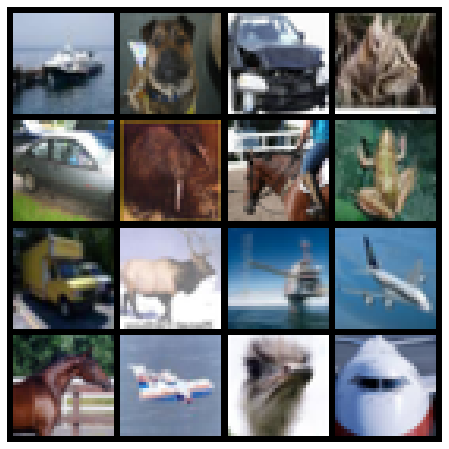

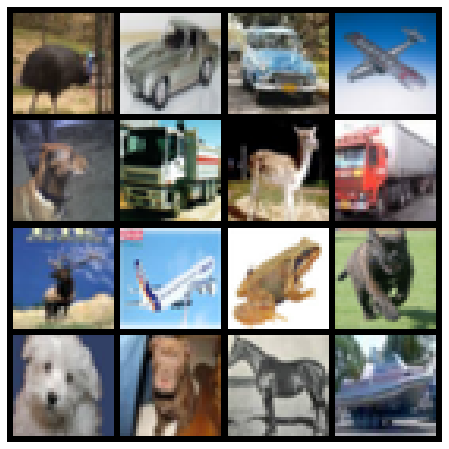

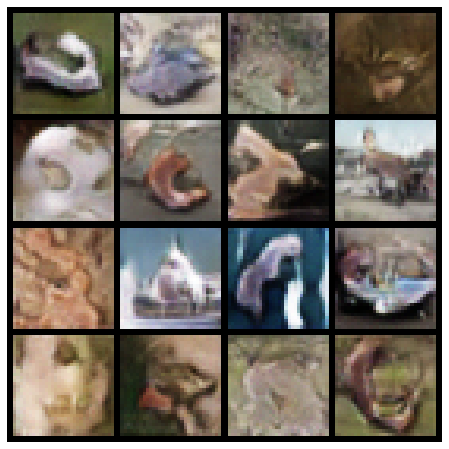

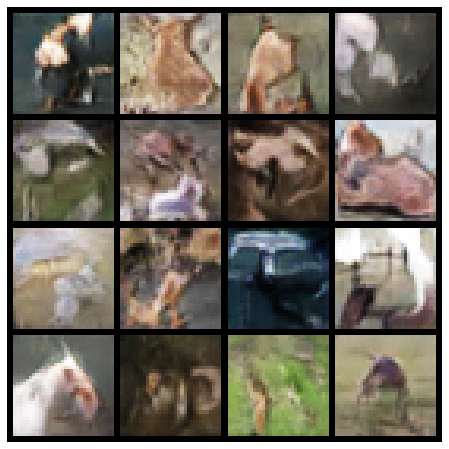

In [282]:
def show_grid(grid):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(grid.permute(1,2,0))

def sample_interpolated_repr(real1, real2):
    repr1, repr2 = get_repr(real1), get_repr(real2)
    repr = slerp(repr1, repr2)
    #repr = lerp(repr1, repr2)
    return repr

def show_sample(data_sampler):
    x, _ = next(data_sampler)
    #plt.hist(F.normalize(simsiam.encoder(x)).detach()[0].cpu().numpy()); return
    x1 = x.cuda(args.gpu)[:16]
    x2 = x.cuda(args.gpu)[16:32]
    show_grid(vutils.make_grid(inv_normalize(x1).cpu(), padding=2, nrow=4))
    show_grid(vutils.make_grid(inv_normalize(x2).cpu(), padding=2, nrow=4))

    model.eval()
    with torch.no_grad():
        x_fake1 = sample_G(sample_interpolated_repr(x1, x2))
        x_fake2 = sample_G(sample_interpolated_repr(x1, x2))
    show_grid(vutils.make_grid(inv_normalize(x_fake1).cpu(), padding=2, nrow=4))
    show_grid(vutils.make_grid(inv_normalize(x_fake2).cpu(), padding=2, nrow=4))

data_sampler = iter(train_loader)
show_sample(data_sampler)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


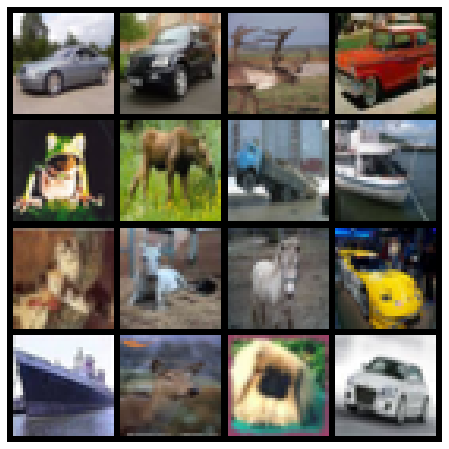

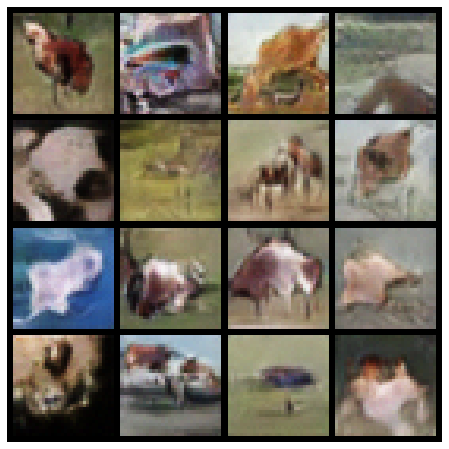

In [281]:
def show_sample2(data_sampler):
    x, _ = next(data_sampler)
    x = x.cuda(args.gpu)[:16]
    show_grid(vutils.make_grid(inv_normalize(x).cpu(), padding=2, nrow=4))
    model.eval()
    with torch.no_grad():
        x_fake = sample_G(get_repr(x))
    show_grid(vutils.make_grid(inv_normalize(x_fake).cpu(), padding=2, nrow=4))

show_sample2(data_sampler)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


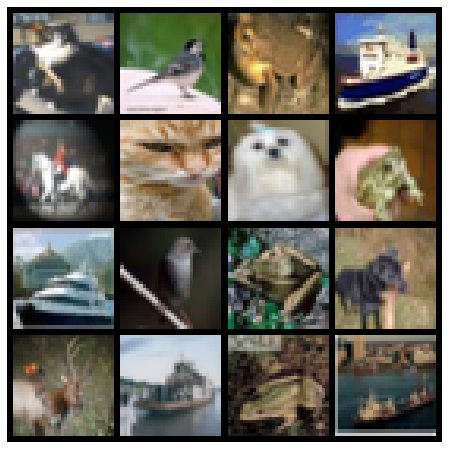

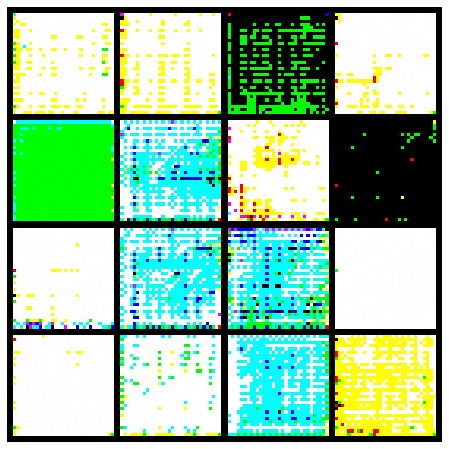

In [276]:
def show_sample3(data_sampler):
    x, _ = next(data_sampler)
    x = x.cuda(args.gpu)[:16]
    show_grid(vutils.make_grid(inv_normalize(x).cpu(), padding=2, nrow=4))
    model.eval()
    with torch.no_grad():
        repr = -1+2*torch.rand(16, args.repr_dim).cuda(args.gpu)
        #repr = torch.randn(16, args.repr_dim).cuda(args.gpu)
        x_fake = sample_G(repr)
    show_grid(vutils.make_grid(inv_normalize(x_fake).cpu(), padding=2, nrow=4))

show_sample3(data_sampler)